In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from functorch import make_functional, vmap, vjp, jvp, jacrev, make_functional_with_buffers
from continuum import ClassIncremental
from continuum.datasets import CIFAR10
from continuum.tasks import split_train_val
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

import warnings
#warnings.filterwarnings("ignore")
DEVICE = "cuda"

C:\Users\xueho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, 32, kernel_size=5),
            # torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3),
            # torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3),
            # torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3),
            # torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        self.layer1 = nn.Linear(64*9*9, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.pool1(x)
        x = self.conv_layer3(x)
        x = torch.flatten(self.conv_layer4(x),start_dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

In [3]:
class NN(nn.Module):
    def __init__(self, layer_sizes):
        super(NN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            m = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            self.linears.append(m)
        
    def forward(self, x):
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x 

In [ ]:
# Prepare Dataset
dataset = CIFAR10("Datasets/CIFAR10/", download=True, train=True) # Change download to True 

scenario = ClassIncremental(
    dataset,
    increment=2,
    initial_increment=2
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

all_datasets = dict()
for task_id, train_taskset in enumerate(scenario):
    all_datasets[task_id] = train_taskset

train_taskset, val_taskset = split_train_val(all_datasets[0], val_split=0.1)
train_loader = DataLoader(train_taskset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_taskset, batch_size=100, shuffle=True)



Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.


In [42]:
layer_sizes = [32*32*3] + [100] * 3 + [1]
net = NN(layer_sizes).to(DEVICE)
 
fnet, params = make_functional(net)
# if your net has buffers
# fnet, params, buffers = make_functional_with_buffers(net)

C:\Users\xueho\AppData\Local\Temp\ipykernel_20020\1860639731.py:4: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


In [6]:
def fnet_single(params, x): # For a single input x
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def empirical_ntk(fnet_single, params, x1, x2, compute='trace'):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]
    
    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False
        
    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

In [56]:
def train_task_i(i):

    def cal_NTK(net,train_taskset,output_dim):
        all_train_loader = DataLoader(train_taskset, batch_size=10000, shuffle=True)
        all_train_data = next(iter(all_train_loader))[0].to(DEVICE) # torch.Size([9000, 3, 32, 32])
        train_data_sub = next(iter(all_train_loader))[0][:output_dim,:,:,:].to(DEVICE) # torch.Size([output_dim, 3, 32, 32])
        train_data_sub = train_data_sub.flatten(start_dim=1)
        _, params= make_functional(net)
        result = empirical_ntk(fnet_single, params, train_data_sub, train_data_sub, 'trace')
        return result

    train_taskset, val_taskset = split_train_val(all_datasets[i], val_split=0.1)
    train_loader = DataLoader(train_taskset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_taskset, batch_size=100, shuffle=True)

    # Hyperparameters
    output_dim = 50
    num_epochs = 5
    learning_rate = 1e-3
    #beta = 0.5 # KL divergence scaling factor
    all_NTK_mat = torch.zeros([num_epochs,output_dim,output_dim])

    # Model, optimizer, and loss function
    #net = CNN(input_dim, hidden_dim, output_dim).to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        net.train()
        for x, y, t in train_loader:
            # Forward pass
            x_batch = torch.flatten(x,start_dim=1)
            x_batch = x_batch.to(DEVICE)
            #outputs = net(x_batch)
            outputs = torch.sigmoid(net(x_batch))
            target = (y-2*i).float()
            nll_loss = criterion(outputs.flatten().cpu(), target)
        
            # Backward pass
            optimizer.zero_grad()
            nll_loss.backward()
            optimizer.step()
        
        net.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            all_NTK_mat[epoch] = cal_NTK(net,train_taskset,output_dim)
            for X_val, y_val_batch, t in val_loader:
                X_val_batch = torch.flatten(X_val,start_dim=1).to(DEVICE)
                #X_val_batch = X_val.to(DEVICE)
                #val_outputs = net(X_val_batch)
                val_outputs = torch.sigmoid(net(X_val_batch)).cpu()
                val_loss += criterion(val_outputs.flatten().cpu(), y_val_batch.float()).item()

                predicted = (val_outputs>0.5).int() + 2*i
                correct += (predicted.flatten() == y_val_batch.flatten()).sum().item()
                total += y_val_batch.size(0)
        val_accuracy = correct / total * 100
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {nll_loss.item():.4f}, Val Loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.2f}%")

    print(f"Training task {i} complete!")
    print(all_NTK_mat)
    return all_NTK_mat

In [60]:
num_tasks = 5
ntk = []
for i in range(num_tasks):
    ntk.append(train_task_i(i))

C:\Users\xueho\AppData\Local\Temp\ipykernel_20020\858377327.py:8: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  _, params= make_functional(net)
C:\Users\xueho\AppData\Local\Temp\ipykernel_20020\1284363017.py:6: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac1 = vmap(jacrev(fnet_single), (None, 0))

Epoch [1/5], Train Loss: 5.8465, Val Loss: 2207.7126, Val accuracy: 81.10%
Epoch [2/5], Train Loss: 3.5000, Val Loss: 2201.8943, Val accuracy: 82.00%
Epoch [3/5], Train Loss: 9.2973, Val Loss: 2202.1586, Val accuracy: 82.10%
Epoch [4/5], Train Loss: 7.5481, Val Loss: 2200.3241, Val accuracy: 81.80%
Epoch [5/5], Train Loss: 5.2092, Val Loss: 2204.2340, Val accuracy: 80.90%
Training task 0 complete!
Epoch [1/5], Train Loss: 3.7442, Val Loss: 11688.7604, Val accuracy: 71.70%
Epoch [2/5], Train Loss: 12.8234, Val Loss: 11688.2273, Val accuracy: 70.70%
Epoch [3/5], Train Loss: 5.2606, Val Loss: 11694.4204, Val accuracy: 72.40%
Epoch [4/5], Train Loss: 12.2853, Val Loss: 11695.5951, Val accuracy: 72.50%
Epoch [5/5], Train Loss: 10.7688, Val Loss: 11692.8782, Val accuracy: 72.50%
Training task 1 complete!
Epoch [1/5], Train Loss: 12.0573, Val Loss: 21144.1008, Val accuracy: 74.10%
Epoch [2/5], Train Loss: 14.0698, Val Loss: 21148.9019, Val accuracy: 75.70%
Epoch [3/5], Train Loss: 9.4402, Val

In [61]:
ntk

[None, None, None, None, None]

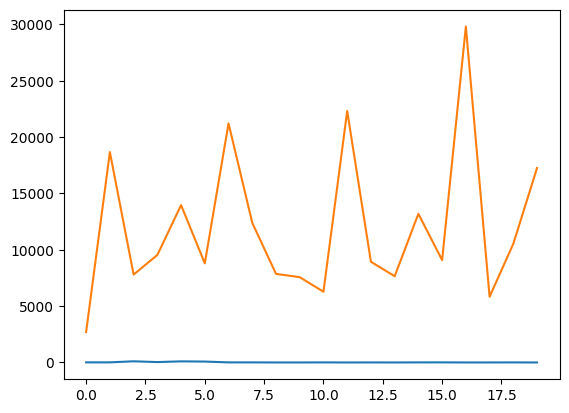

In [48]:
# Plot eigenvalues
a = torch.linalg.eigvals(all_NTK_mat)
max_eig = []
min_eig = []
for i in range(all_NTK_mat.shape[0]):
    max_eig.append(abs(a[i][0].item()))
    min_eig.append(abs(a[i][-1].item()))
    import matplotlib.pyplot as plt
plt.plot(min_eig)
plt.plot(max_eig)

In [ ]:
ntk_result = empirical_ntk(fnet_single, params, x, x, 'trace')
print(ntk_result.shape)
# Compute eigenvalues
lambda_K, eigvec_K = np.linalg.eig(ntk_result.detach().cpu().numpy())
 
# Sort in descresing order
lambda_K = np.sort(np.real(lambda_K))[::-1]
# Visualize the eigenvectors of the NTK
fig, axs= plt.subplots(2, 3, figsize=(12, 6))
X = np.linspace(0, 1, len(x))
axs[0, 0].plot(X, np.real(eigvec_K[:,0]))
axs[0, 1].plot(X, np.real(eigvec_K[:,1]))
axs[0, 2].plot(X, np.real(eigvec_K[:,2]))
axs[1, 0].plot(X, np.real(eigvec_K[:,3]))
axs[1, 1].plot(X, np.real(eigvec_K[:,4]))
axs[1, 2].plot(X, np.real(eigvec_K[:,5]))
plt.show()
 
# Visualize the eigenvalues of the NTK
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(lambda_K)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('index')
ax.set_ylabel(r'$\lambda$') 
plt.show()